In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot  as plt
import seaborn as sb

import fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

from platform import python_version
print('Python Version',python_version())
print('Pandas Version',pd.__version__)
print('Numpy Version',np.__version__)
print('FbProphet Version',fbprophet.__version__)

import warnings
warnings.filterwarnings('ignore')

Python Version 3.8.8
Pandas Version 1.2.4
Numpy Version 1.18.5
FbProphet Version 0.7.1


### Data Collection

In [2]:
btc = pd.read_csv("archive/coin_Bitcoin.csv")
# btc = pd.read_csv("archive/coin_Bitcoin.csv")
print(btc.info())
btc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2862 non-null   int64  
 1   Name       2862 non-null   object 
 2   Symbol     2862 non-null   object 
 3   Date       2862 non-null   object 
 4   High       2862 non-null   float64
 5   Low        2862 non-null   float64
 6   Open       2862 non-null   float64
 7   Close      2862 non-null   float64
 8   Volume     2862 non-null   float64
 9   Marketcap  2862 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 223.7+ KB
None


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,29-04-2013 23:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,30-04-2013 23:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,01-05-2013 23:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,02-05-2013 23:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,03-05-2013 23:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


### Preprocessing on Date

In [3]:
pd.to_datetime(btc.Date,errors='coerce') #Formats are disturbed

0      2013-04-29 23:59:00
1      2013-04-30 23:59:00
2      2013-01-05 23:59:00
3      2013-02-05 23:59:00
4      2013-03-05 23:59:00
               ...        
2857   2021-02-23 23:59:00
2858   2021-02-24 23:59:00
2859   2021-02-25 23:59:00
2860   2021-02-26 23:59:00
2861   2021-02-27 23:59:00
Name: Date, Length: 2862, dtype: datetime64[ns]

##### The moment I convert Date columns to datetime format using:
pd.to_datetime(btc['Date'])
##### or while reading the file itself using : 
date_par = lambda x: datetime.strptime(x, '%Y-%m-%d%H:%M')<br>
date_par = lambda x: pd.to_datetime(x)<br>

Pandas is not able to format the dates properly , somewhere the format is YYYY-MM-DD and somewhere is it YYYY-DD-MM and making the entire columns garbage for the analysis.

Let's first get rid of timming and then we will convert the date columns to datetime format.

In [4]:
# btc.Date.str.split()[0]
btc['Date'] = [li[0] for li in btc.Date.str.split()]
pd.to_datetime(btc['Date'])

0      2013-04-29
1      2013-04-30
2      2013-01-05
3      2013-02-05
4      2013-03-05
          ...    
2857   2021-02-23
2858   2021-02-24
2859   2021-02-25
2860   2021-02-26
2861   2021-02-27
Name: Date, Length: 2862, dtype: datetime64[ns]

In [5]:
'''Even after removing time from the date columns, the date formatting is the issue.
'''
#This is the issue with pandas
# https://github.com/pandas-dev/pandas/issues/25847

'Even after removing time from the date columns, the date formatting is the issue.\n'

In [6]:
btc.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,29-04-2013,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,30-04-2013,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,01-05-2013,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,02-05-2013,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,03-05-2013,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [7]:
btc['Day'] = [date[0] for date in btc.Date.str.split('-')]
btc['Month'] = [date[1] for date in btc.Date.str.split('-')]
btc['Year'] = [date[2] for date in btc.Date.str.split('-')]
btc.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Day,Month,Year
0,1,Bitcoin,BTC,29-04-2013,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,29,04,2013
1,2,Bitcoin,BTC,30-04-2013,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,30,04,2013
2,3,Bitcoin,BTC,01-05-2013,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,01,05,2013
3,4,Bitcoin,BTC,02-05-2013,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,02,05,2013
4,5,Bitcoin,BTC,03-05-2013,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,03,05,2013


In [8]:
#Converting date column to correct date format

# btc['Date'] = [datetime.strptime(date, '%d-%m-%Y').date() for date in btc['Date']]

btc['Date'] = btc['Date'].apply(lambda x : datetime.strptime(x, '%d-%m-%Y').date())
btc

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Day,Month,Year
0,1,Bitcoin,BTC,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,29,04,2013
1,2,Bitcoin,BTC,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,30,04,2013
2,3,Bitcoin,BTC,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,01,05,2013
3,4,Bitcoin,BTC,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,02,05,2013
4,5,Bitcoin,BTC,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,03,05,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,2858,Bitcoin,BTC,2021-02-23,54204.929760,45290.590270,54204.929760,48824.426870,1.061020e+11,9.099260e+11,23,02,2021
2858,2859,Bitcoin,BTC,2021-02-24,51290.136690,47213.498160,48835.087660,49705.333320,6.369552e+10,9.263930e+11,24,02,2021
2859,2860,Bitcoin,BTC,2021-02-25,51948.966980,47093.853020,49709.082420,47093.853020,5.450657e+10,8.777660e+11,25,02,2021
2860,2861,Bitcoin,BTC,2021-02-26,48370.785260,44454.842110,47180.464050,46339.760080,3.509680e+11,8.637520e+11,26,02,2021


In [9]:
btc.Date[0]

datetime.date(2013, 4, 29)

### Exploratory Data Analysis

<AxesSubplot:>

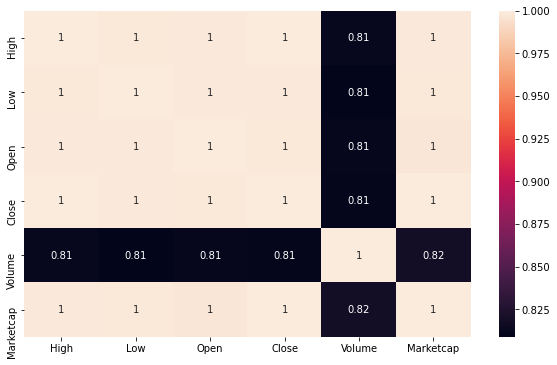

In [10]:
plt.figure(figsize=(10,6))
sb.heatmap(btc.drop(['SNo'],axis=1).corr(),annot=True)

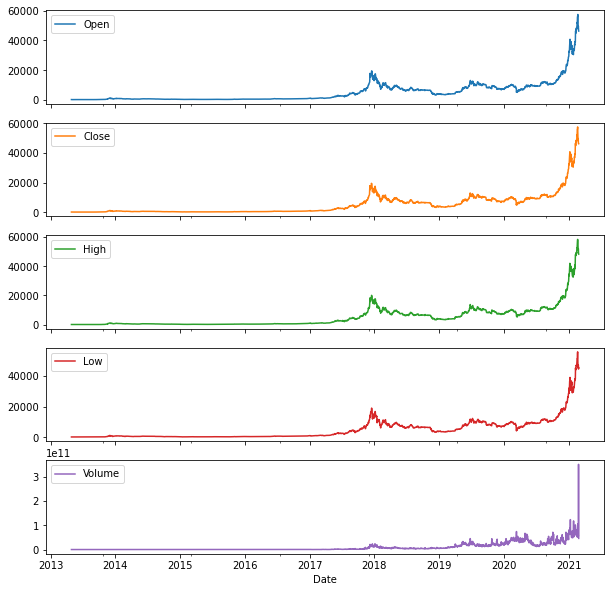

In [11]:
btc.set_index('Date',inplace=True)
btc[['Open','Close','High','Low','Volume']].plot(subplots=True,figsize=(10,10))
btc.reset_index(inplace=True)

Volume is the coins purchased

<AxesSubplot:xlabel='Year'>

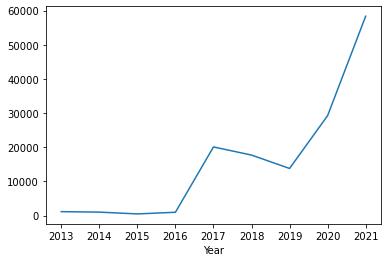

In [12]:
btc.groupby('Year').High.max().plot(kind='line')

In [13]:
'''How much price increased from 2013 till 2021'''

print('Price Increased since 2013 in % is :',((btc.groupby('Year').High.max()[-1] - btc.groupby('Year').High.max()[0])/btc.groupby('Year').High.max()[0])*100)

Price Increased since 2013 in % is : 4945.2861576631785


In [14]:
btc.groupby('Year').High.max()

Year
2013     1156.140015
2014     1017.119995
2015      495.562012
2016      979.396973
2017    20089.000000
2018    17712.400390
2019    13796.489080
2020    29244.876690
2021    58330.572140
Name: High, dtype: float64

In [15]:
btc.groupby(['Year','Month']).High.max().head(60)

Year  Month
2013  04         147.488007
      05         139.889999
      06         129.779999
      07         111.344002
      08         140.889999
      09         146.500000
      10         217.419998
      11        1156.140015
      12        1156.119995
2014  01        1017.119995
      02         853.520019
      03         702.909973
      04         542.377991
      05         624.715027
      06         674.111023
      07         657.857971
      08         598.116028
      09         493.928009
      10         411.697998
      11         457.092987
      12         384.037994
2015  01         320.434998
      02         265.610992
      03         300.044006
      04         261.798004
      05         247.804001
      06         267.867004
      07         314.394012
      08         285.714996
      09         259.182007
      10         334.169006
      11         495.562012
      12         469.102997
2016  01         462.933990
      02         448.045990
      03

In [16]:
btc.head()

,Date,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Day,Month,Year
0,2013-04-29,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,29,04,2013
1,2013-04-30,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,30,04,2013
2,2013-05-01,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,01,05,2013
3,2013-05-02,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,02,05,2013
4,2013-05-03,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,03,05,2013


### Altcoins data

In [17]:
doge = pd.read_csv("archive/coin_Dogecoin.csv")
ripple = pd.read_csv("archive/coin_XRP.csv")
ether = pd.read_csv("archive/coin_Ethereum.csv")

#Ether's data is captured from 8-8-2015 , we want to filter the data for other altcoins from that date only so we can find relationship among them.
th = datetime.strptime(ether.Date[0].split()[0], '%Y-%m-%d').date()

def preprocess_altcoins(df):
    df['Date'] = [li[0] for li in df.Date.str.split()]
    df['Date'] = df['Date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d').date())
    
preprocess_altcoins(doge)
preprocess_altcoins(ripple)
preprocess_altcoins(ether)

doge = doge[doge.Date>=th]
ripple = ripple[ripple.Date>=th]
ether = ether[ether.Date>=th]
temp_btc = btc[btc.Date>=th].copy()


#Creating a dataframe with High values of each altcoin and bitcoin.
altcoins = pd.DataFrame({
    'BTC':list(temp_btc.High),
    'DOGE':list(doge.High),
    'Ripple_XRP':list(ripple.High),
    'ETHER':list(ether.High)
})

altcoins.head()

,BTC,DOGE,Ripple_XRP,ETHER
0,279.928009,0.000171,0.008708,2.798810
1,267.002991,0.000163,0.008823,0.879810
2,267.032013,0.000164,0.008905,0.729854
3,270.385986,0.000164,0.008766,1.131410
4,270.673004,0.000166,0.008593,1.289940


<AxesSubplot:>

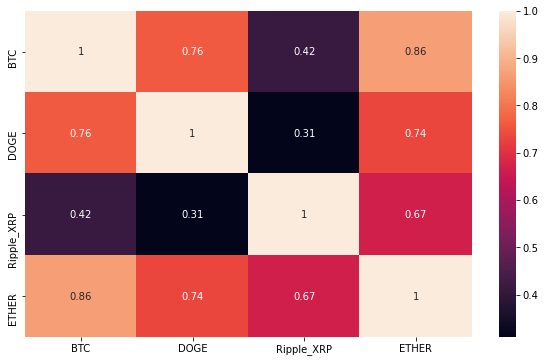

In [18]:
plt.figure(figsize=(10,6))
sb.heatmap(altcoins.corr(),annot=True)

### Data Selection

In [19]:
btc

,Date,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Day,Month,Year
0,2013-04-29,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,29,04,2013
1,2013-04-30,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,30,04,2013
2,2013-05-01,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,01,05,2013
3,2013-05-02,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,02,05,2013
4,2013-05-03,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,03,05,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,2021-02-23,2858,Bitcoin,BTC,54204.929760,45290.590270,54204.929760,48824.426870,1.061020e+11,9.099260e+11,23,02,2021
2858,2021-02-24,2859,Bitcoin,BTC,51290.136690,47213.498160,48835.087660,49705.333320,6.369552e+10,9.263930e+11,24,02,2021
2859,2021-02-25,2860,Bitcoin,BTC,51948.966980,47093.853020,49709.082420,47093.853020,5.450657e+10,8.777660e+11,25,02,2021
2860,2021-02-26,2861,Bitcoin,BTC,48370.785260,44454.842110,47180.464050,46339.760080,3.509680e+11,8.637520e+11,26,02,2021


In [20]:
'''Filtering the data from 2017 to 2021'''

btc = btc[btc['Year'].isin(['2017','2018','2019','2020','2021'])].copy()

print(btc.shape)
btc.head()

(1519, 13)


,Date,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Day,Month,Year
1343,2017-01-01,1344,Bitcoin,BTC,1003.080017,958.698975,963.658020,998.325012,147775008.0,1.605041e+10,01,01,2017
1344,2017-01-02,1345,Bitcoin,BTC,1031.390015,996.702026,998.617004,1021.750000,222184992.0,1.642902e+10,02,01,2017
1345,2017-01-03,1346,Bitcoin,BTC,1044.079956,1021.599976,1021.599976,1043.839966,185168000.0,1.678637e+10,03,01,2017
1346,2017-01-04,1347,Bitcoin,BTC,1159.420044,1044.400024,1044.400024,1154.729980,344945984.0,1.857187e+10,04,01,2017
1347,2017-01-05,1348,Bitcoin,BTC,1191.099976,910.416992,1156.729980,1013.380005,510199008.0,1.630025e+10,05,01,2017


In [21]:
'''This data will be used for Modelling.'''

data = btc[['Date','High']].copy()

print(data.shape)
data.head()
data.tail()

(1519, 2)


,Date,High
2857,2021-02-23,54204.92976
2858,2021-02-24,51290.13669
2859,2021-02-25,51948.96698
2860,2021-02-26,48370.78526
2861,2021-02-27,48253.27010


- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

### Simple Moving Average

In [22]:
'''Monthly Average Highest Price'''

btc['Year_Month_identifier'] = btc['Year'] + btc['Month']
visual_data_month = pd.pivot_table(btc,values='High',index='Year_Month_identifier',aggfunc=np.mean).reset_index()
btc.drop('Year_Month_identifier',axis=1,inplace=True)
visual_data_month.head()

,Year_Month_identifier,High
0,201701,937.449585
1,201702,1073.503898
2,201703,1161.893269
3,201704,1216.302983
4,201705,1968.786782


In [23]:
visual_data_month.tail()

,Year_Month_identifier,High
45,202010,12018.847827
46,202011,16945.980407
47,202012,22354.685698
48,202101,36206.557029
49,202102,47747.229024


Text(0, 0.5, 'USD')

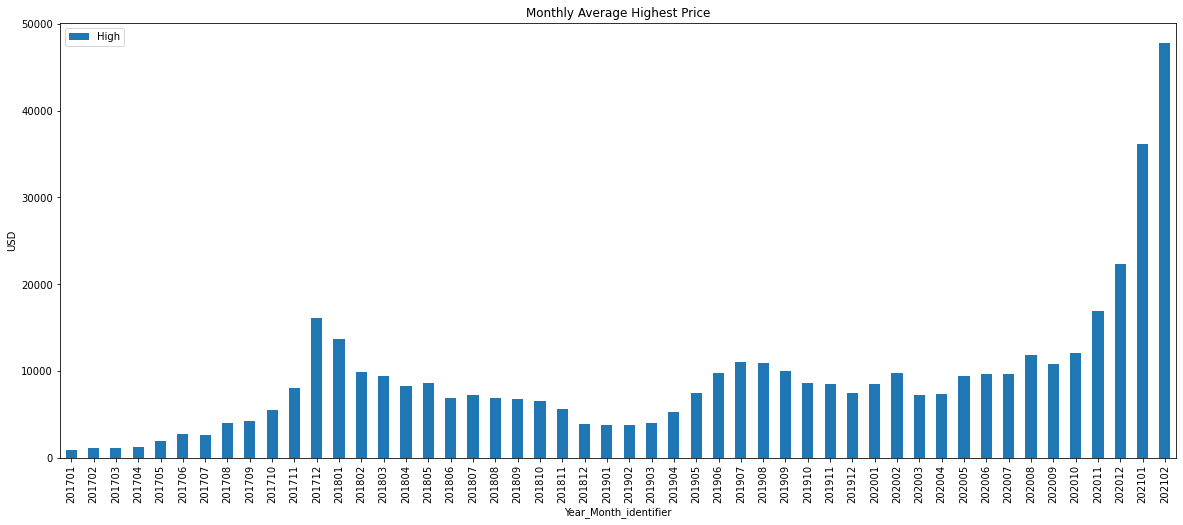

In [24]:
visual_data_month.plot(kind='bar',figsize=(20,8),x='Year_Month_identifier',y='High')
plt.title("Monthly Average Highest Price") # Rational of why are we seeing it
plt.ylabel('USD')

Moving Average is simply most Naive approach of making predictions of time series.
In Which, we take last N days data's average as predictions.

In [25]:
print(data.shape)
data.head()
data.tail()

(1519, 2)


,Date,High
2857,2021-02-23,54204.92976
2858,2021-02-24,51290.13669
2859,2021-02-25,51948.96698
2860,2021-02-26,48370.78526
2861,2021-02-27,48253.27010


<AxesSubplot:xlabel='Date'>

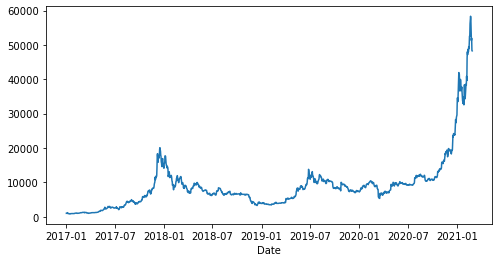

In [26]:
data.set_index('Date',inplace=True)
data.High.plot(figsize=(8,4))

In [27]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


moving_average(data['High'], 20)  # prediction for the last observed day

51193.6717705

In [28]:
# data.High.tail(30)

In [29]:
# data.High.rolling(window=10).mean().tail(30)

In [30]:
def plotMovingAverage(series, window):

    """
        series - dataframe with timeseries
        window - rolling window size 
       
    """
    global rolling_mean
    rolling_mean = series.rolling(window=window).mean()
    
    rmse = mean_squared_error(series[window:], rolling_mean[window:],squared=False)
    print('root_mean_squared_error = ',rmse)
    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean predictions")

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

root_mean_squared_error =  1033.0186918225038


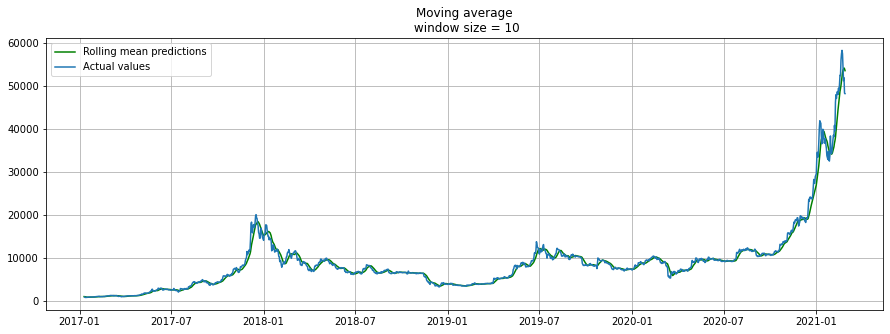

In [31]:
plotMovingAverage(data.High,10)

root_mean_squared_error =  2141.4424345533384


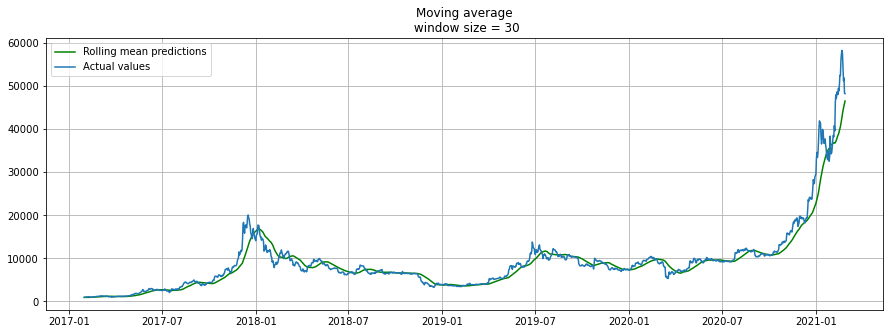

In [32]:
plotMovingAverage(data.High,30)

### Additive Regressive Model using FbProphet

In [33]:
data.head()

,High
Date,
2017-01-01,1003.080017
2017-01-02,1031.390015
2017-01-03,1044.079956
2017-01-04,1159.420044
2017-01-05,1191.099976


<AxesSubplot:xlabel='Date'>

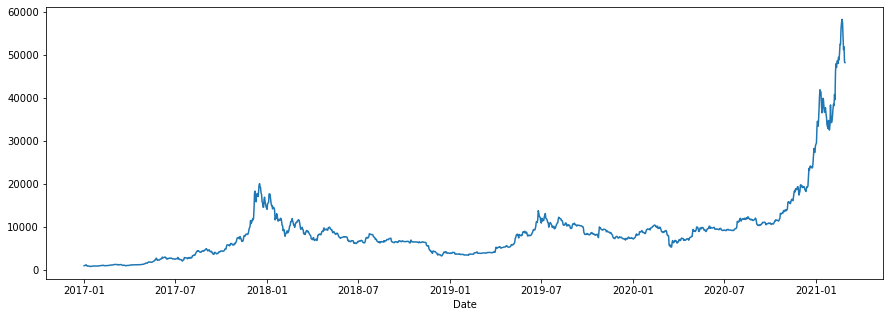

In [34]:
data.High.plot(figsize=(15,5))

In [35]:
data.reset_index(inplace=True)
data.head()

,Date,High
0,2017-01-01,1003.080017
1,2017-01-02,1031.390015
2,2017-01-03,1044.079956
3,2017-01-04,1159.420044
4,2017-01-05,1191.099976


In [36]:
data.columns = data.columns.map({'Date':'ds','High':'y'})
data

,ds,y
0,2017-01-01,1003.080017
1,2017-01-02,1031.390015
2,2017-01-03,1044.079956
3,2017-01-04,1159.420044
4,2017-01-05,1191.099976
...,...,...
1514,2021-02-23,54204.929760
1515,2021-02-24,51290.136690
1516,2021-02-25,51948.966980
1517,2021-02-26,48370.785260


The authors of the library generally advise to make predictions based on at least several months, ideally, more than a year of historical data. Luckily, in our case we have more than a couple of years of data to fit the model.

In [37]:
#Train and Test data , records of year 2021 is taken as test data and records from 2017 to 2020 will be our train data.

test_df = data[data.ds>=pd.to_datetime('2021-01-01')]
train_df = data[data.ds<pd.to_datetime('2021-01-01')]

print('Entire Data :',data.shape)
print('Training Data :',train_df.shape)
print('Testing Data :',test_df.shape)
pred_size = test_df.shape[0]
print('Number of Records in Testing data, Basically for which we want to Predict is {}'.format(pred_size))

Entire Data : (1519, 2)
Training Data : (1461, 2)
Testing Data : (58, 2)
Number of Records in Testing data, Basically for which we want to Predict is 58


In [38]:
train_df.tail(5)

,ds,y
1456,2020-12-27,28288.84002
1457,2020-12-28,27389.11206
1458,2020-12-29,27370.72008
1459,2020-12-30,28937.74000
1460,2020-12-31,29244.87669


In [207]:
pphet = Prophet()
pphet.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [208]:
# make_future_dataframe() will create the dataframe of dates from train set dates to the date to which we want to extend , giving predsize == size of test data

future = pphet.make_future_dataframe(periods=pred_size)
print(future.shape)
future.head()

(1519, 1)


,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05


In [209]:
future.tail()

,ds
1514,2021-02-23
1515,2021-02-24
1516,2021-02-25
1517,2021-02-26
1518,2021-02-27


We predict values with `Prophet` by passing in the dates for which we want to create a forecast. If we also supply the historical dates (as in our case), then in addition to the prediction we will get an in-sample fit for the history. Let's call the model's `predict` method with our `future` dataframe as an input:

In [210]:
forecast = pphet.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,-1862.576978,389.067015,3652.335056,-1862.576978,-1862.576978,3843.241382,3843.241382,3843.241382,-24.736262,-24.736262,-24.736262,3867.977644,3867.977644,3867.977644,0.0,0.0,0.0,1980.664404
1,2017-01-02,-1830.026431,358.614183,3537.929868,-1830.026431,-1830.026431,3785.557140,3785.557140,3785.557140,-0.290987,-0.290987,-0.290987,3785.848127,3785.848127,3785.848127,0.0,0.0,0.0,1955.530709
2,2017-01-03,-1797.475884,205.183435,3590.173640,-1797.475884,-1797.475884,3706.879251,3706.879251,3706.879251,7.410317,7.410317,7.410317,3699.468934,3699.468934,3699.468934,0.0,0.0,0.0,1909.403367
3,2017-01-04,-1764.925337,206.465667,3503.507722,-1764.925337,-1764.925337,3637.720036,3637.720036,3637.720036,27.798497,27.798497,27.798497,3609.921539,3609.921539,3609.921539,0.0,0.0,0.0,1872.794699
4,2017-01-05,-1732.374791,132.767201,3405.490453,-1732.374791,-1732.374791,3562.279321,3562.279321,3562.279321,44.053565,44.053565,44.053565,3518.225756,3518.225756,3518.225756,0.0,0.0,0.0,1829.904530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,2021-02-23,19658.254317,19439.760023,22971.546036,19015.467421,20200.201525,1598.343550,1598.343550,1598.343550,7.410317,7.410317,7.410317,1590.933234,1590.933234,1590.933234,0.0,0.0,0.0,21256.597867
1515,2021-02-24,19694.362425,19506.127664,23027.899430,19027.950779,20251.205674,1606.106650,1606.106650,1606.106650,27.798497,27.798497,27.798497,1578.308153,1578.308153,1578.308153,0.0,0.0,0.0,21300.469075
1516,2021-02-25,19730.470532,19502.017093,23284.248329,19046.757093,20313.436107,1602.917564,1602.917564,1602.917564,44.053565,44.053565,44.053565,1558.863999,1558.863999,1558.863999,0.0,0.0,0.0,21333.388097
1517,2021-02-26,19766.578640,19450.471637,23094.024983,19054.500131,20371.794625,1495.111946,1495.111946,1495.111946,-36.879564,-36.879564,-36.879564,1531.991509,1531.991509,1531.991509,0.0,0.0,0.0,21261.690586


In the resulting dataframe we can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the `yhat` column.

The Prophet library has its own built-in tools for visualization that enable us to quickly evaluate the result.

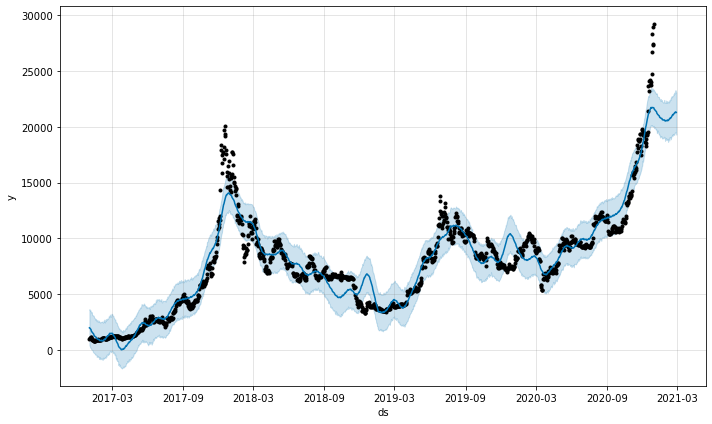

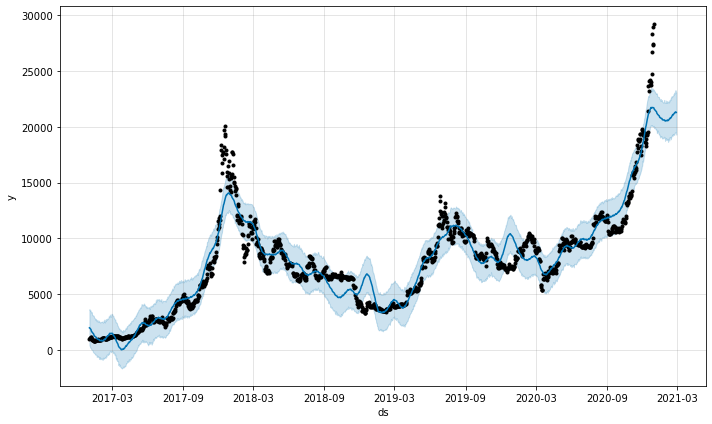

In [212]:
pphet.plot(forecast)

# Black Dots --> Data used to train the model 
# Blue Line --> Line fitting through Data or Predictions based on learning 
# Blue Haze --> uncertainty intervals of predictions; lower the better 

In [214]:
data

,ds,y
0,2017-01-01,1003.080017
1,2017-01-02,1031.390015
2,2017-01-03,1044.079956
3,2017-01-04,1159.420044
4,2017-01-05,1191.099976
...,...,...
1514,2021-02-23,54204.929760
1515,2021-02-24,51290.136690
1516,2021-02-25,51948.966980
1517,2021-02-26,48370.785260


In [215]:
forecast[['ds','yhat']]

,ds,yhat
0,2017-01-01,1980.664404
1,2017-01-02,1955.530709
2,2017-01-03,1909.403367
3,2017-01-04,1872.794699
4,2017-01-05,1829.904530
...,...,...
1514,2021-02-23,21256.597867
1515,2021-02-24,21300.469075
1516,2021-02-25,21333.388097
1517,2021-02-26,21261.690586


In [111]:
mean_squared_error(data.y,forecast.yhat,squared=False)

4476.2001072418125

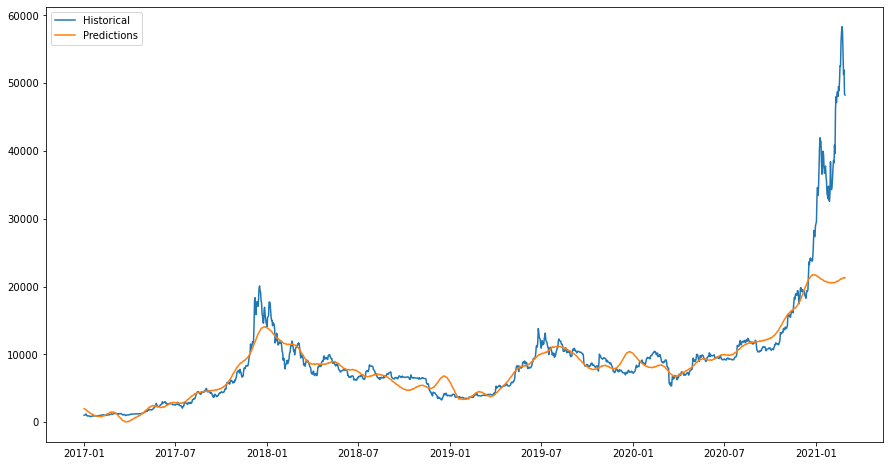

In [157]:
plt.figure(figsize=(15,8))
plt.plot(data.set_index('ds')['y'],label='Historical')
plt.plot(forecast.set_index('ds')['yhat'],label='Predictions')
plt.legend()

Prophet is not able to predict the future since in 2021 there is a sudden peak which model has no idea.

In [217]:
pphet2 = Prophet()
pphet2.fit(data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [218]:
future_ = pphet2.make_future_dataframe(periods=0)
print(future_.shape)
future_.head()

(1519, 1)


,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05


In [219]:
future_.tail()

,ds
1514,2021-02-23
1515,2021-02-24
1516,2021-02-25
1517,2021-02-26
1518,2021-02-27


In [220]:
forecast_ = pphet2.predict(future_)
forecast_

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,-1655.433282,-3591.297477,640.161948,-1655.433282,-1655.433282,304.350955,304.350955,304.350955,-17.660499,-17.660499,-17.660499,322.011454,322.011454,322.011454,0.0,0.0,0.0,-1351.082327
1,2017-01-02,-1697.047141,-3313.190430,1162.304743,-1697.047141,-1697.047141,611.508658,611.508658,611.508658,3.493251,3.493251,3.493251,608.015407,608.015407,608.015407,0.0,0.0,0.0,-1085.538484
2,2017-01-03,-1738.661001,-2901.911193,1281.916823,-1738.661001,-1738.661001,865.353365,865.353365,865.353365,-12.471178,-12.471178,-12.471178,877.824543,877.824543,877.824543,0.0,0.0,0.0,-873.307635
3,2017-01-04,-1780.274860,-2778.243789,1356.550789,-1780.274860,-1780.274860,1126.305795,1126.305795,1126.305795,-2.460447,-2.460447,-2.460447,1128.766243,1128.766243,1128.766243,0.0,0.0,0.0,-653.969064
4,2017-01-05,-1821.888719,-2519.859148,1648.615585,-1821.888719,-1821.888719,1393.666909,1393.666909,1393.666909,35.202595,35.202595,35.202595,1358.464314,1358.464314,1358.464314,0.0,0.0,0.0,-428.221809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,2021-02-23,38265.386313,43763.283296,47944.986121,38265.386313,38265.386313,7531.287990,7531.287990,7531.287990,-12.471178,-12.471178,-12.471178,7543.759167,7543.759167,7543.759167,0.0,0.0,0.0,45796.674302
1515,2021-02-24,38392.136363,43971.835128,48144.931304,38392.136363,38392.136363,7536.142425,7536.142425,7536.142425,-2.460447,-2.460447,-2.460447,7538.602872,7538.602872,7538.602872,0.0,0.0,0.0,45928.278788
1516,2021-02-25,38518.886414,44193.831565,48229.100297,38518.886414,38518.886414,7540.569995,7540.569995,7540.569995,35.202595,35.202595,35.202595,7505.367399,7505.367399,7505.367399,0.0,0.0,0.0,46059.456408
1517,2021-02-26,38645.636464,44076.898133,48336.550293,38645.636464,38645.636464,7441.006138,7441.006138,7441.006138,-5.246722,-5.246722,-5.246722,7446.252860,7446.252860,7446.252860,0.0,0.0,0.0,46086.642602


In [230]:
mean_squared_error(data.y,forecast_.yhat,squared=False)

1644.463742966044

In [231]:
data

,ds,y
0,2017-01-01,1003.080017
1,2017-01-02,1031.390015
2,2017-01-03,1044.079956
3,2017-01-04,1159.420044
4,2017-01-05,1191.099976
...,...,...
1514,2021-02-23,54204.929760
1515,2021-02-24,51290.136690
1516,2021-02-25,51948.966980
1517,2021-02-26,48370.785260


In [232]:
forecast_[['ds','yhat']]

,ds,yhat
0,2017-01-01,-1351.082327
1,2017-01-02,-1085.538484
2,2017-01-03,-873.307635
3,2017-01-04,-653.969064
4,2017-01-05,-428.221809
...,...,...
1514,2021-02-23,45796.674302
1515,2021-02-24,45928.278788
1516,2021-02-25,46059.456408
1517,2021-02-26,46086.642602


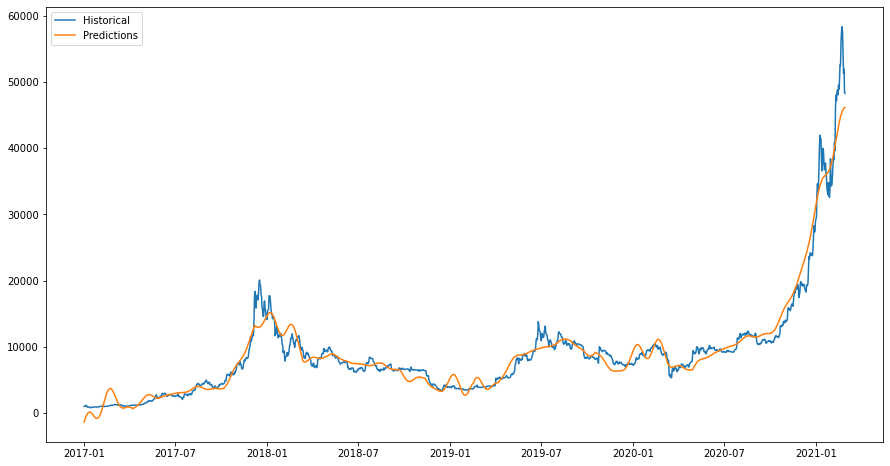

In [185]:
plt.figure(figsize=(15,8))
plt.plot(data.set_index('ds')['y'],label='Historical')
plt.plot(forecast_.set_index('ds')['yhat'],label='Predictions')
plt.legend()

In [241]:
future_unseen = pphet2.make_future_dataframe(periods=60)
print(future_unseen.shape)
future_unseen.head()

(1579, 1)


,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05


In [242]:
future_unseen.tail()

,ds
1574,2021-04-24
1575,2021-04-25
1576,2021-04-26
1577,2021-04-27
1578,2021-04-28


In [243]:
unseen_forecast = pphet2.predict(future_unseen)
unseen_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,-1655.433282,-3580.319689,534.145771,-1655.433282,-1655.433282,304.350955,304.350955,304.350955,-17.660499,-17.660499,-17.660499,322.011454,322.011454,322.011454,0.0,0.0,0.0,-1351.082327
1,2017-01-02,-1697.047141,-3072.966635,1015.358524,-1697.047141,-1697.047141,611.508658,611.508658,611.508658,3.493251,3.493251,3.493251,608.015407,608.015407,608.015407,0.0,0.0,0.0,-1085.538484
2,2017-01-03,-1738.661001,-3158.217456,1181.248255,-1738.661001,-1738.661001,865.353365,865.353365,865.353365,-12.471178,-12.471178,-12.471178,877.824543,877.824543,877.824543,0.0,0.0,0.0,-873.307635
3,2017-01-04,-1780.274860,-2682.066484,1464.967417,-1780.274860,-1780.274860,1126.305795,1126.305795,1126.305795,-2.460447,-2.460447,-2.460447,1128.766243,1128.766243,1128.766243,0.0,0.0,0.0,-653.969064
4,2017-01-05,-1821.888719,-2439.014555,1701.997972,-1821.888719,-1821.888719,1393.666909,1393.666909,1393.666909,35.202595,35.202595,35.202595,1358.464314,1358.464314,1358.464314,0.0,0.0,0.0,-428.221809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,2021-04-24,45870.389346,48543.857880,55435.607644,43037.615060,48752.706336,6124.367318,6124.367318,6124.367318,-0.857000,-0.857000,-0.857000,6125.224318,6125.224318,6125.224318,0.0,0.0,0.0,51994.756664
1575,2021-04-25,45997.139397,48532.586429,55609.521302,43028.132462,48990.827631,6143.121778,6143.121778,6143.121778,-17.660499,-17.660499,-17.660499,6160.782277,6160.782277,6160.782277,0.0,0.0,0.0,52140.261175
1576,2021-04-26,46123.889448,48732.190195,55872.494463,43096.532884,49204.881019,6201.335730,6201.335730,6201.335730,3.493251,3.493251,3.493251,6197.842479,6197.842479,6197.842479,0.0,0.0,0.0,52325.225178
1577,2021-04-27,46250.639498,49020.312237,56200.059518,43134.050075,49392.506051,6222.714851,6222.714851,6222.714851,-12.471178,-12.471178,-12.471178,6235.186028,6235.186028,6235.186028,0.0,0.0,0.0,52473.354349


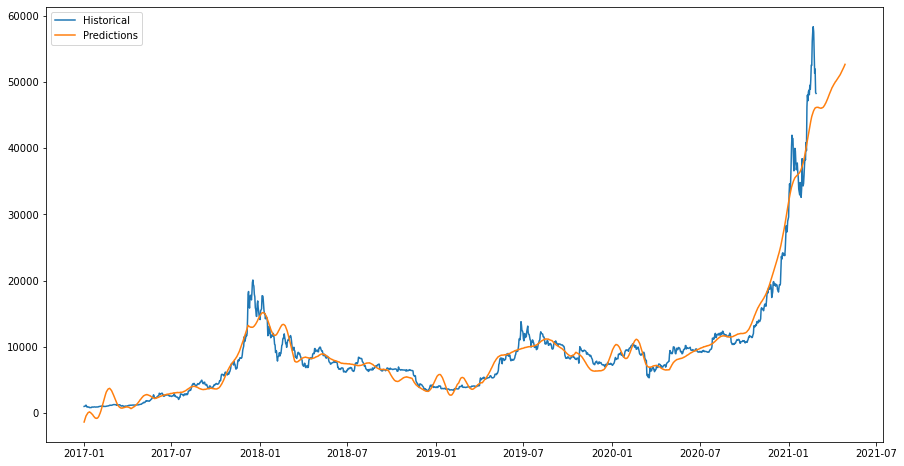

In [244]:
plt.figure(figsize=(15,8))
plt.plot(data.set_index('ds')['y'],label='Historical')
plt.plot(unseen_forecast.set_index('ds')['yhat'],label='Predictions')
plt.legend()

### Deep Learning 

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
print('Tensorflow Version',tf.__version__)
print('Numpy Version',np.__version__)

Tensorflow Version 2.3.0
Numpy Version 1.18.5


In [38]:
data

,ds,y
0,2017-01-01,1003.080017
1,2017-01-02,1031.390015
2,2017-01-03,1044.079956
3,2017-01-04,1159.420044
4,2017-01-05,1191.099976
...,...,...
1514,2021-02-23,54204.929760
1515,2021-02-24,51290.136690
1516,2021-02-25,51948.966980
1517,2021-02-26,48370.785260


In [39]:
features_X = data['y'] #.drop('ds',axis=1)
target_y = data['y']
features_X

0        1003.080017
1        1031.390015
2        1044.079956
3        1159.420044
4        1191.099976
            ...     
1514    54204.929760
1515    51290.136690
1516    51948.966980
1517    48370.785260
1518    48253.270100
Name: y, Length: 1519, dtype: float64

In [40]:
features_X = features_X.to_numpy().reshape(features_X.shape[0],1)
target_y = target_y.to_numpy().reshape(target_y.shape[0],1)
print(features_X.shape)
print(target_y.shape)

(1519, 1)
(1519, 1)


In [41]:
features_X

array([[ 1003.080017],
       [ 1031.390015],
       [ 1044.079956],
       ...,
       [51948.96698 ],
       [48370.78526 ],
       [48253.2701  ]])

In [42]:
# print(test_df.shape)
# test_df.head()

In [43]:
# X_test = test_df['y']
# y_test = test_df['y']

In [44]:
# X_test = X_test.to_numpy().reshape(X_test.shape[0],1)
# y_test = y_test.to_numpy().reshape(y_test.shape[0],1)
# print(X_test.shape)
# print(y_test.shape)

In [45]:
ts_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(features_X, target_y, 
                                                                   length=3, 
                                                                   batch_size=1,
                                                                   stride=1,
                                                                   sampling_rate=1 )

In [46]:
print(ts_generator[0])
print('\n',ts_generator[1])
print('\n',ts_generator[2])

(array([[[1003.080017],
        [1031.390015],
        [1044.079956]]]), array([[1159.420044]]))

 (array([[[1031.390015],
        [1044.079956],
        [1159.420044]]]), array([[1191.099976]]))

 (array([[[1044.079956],
        [1159.420044],
        [1191.099976]]]), array([[1046.810059]]))


In [47]:
print(ts_generator[0][0].shape)
print(ts_generator[0][0].ndim)
print(len(ts_generator))

(1, 3, 1)
3
1516


In [48]:
ts_generator[0][0]

array([[[1003.080017],
        [1031.390015],
        [1044.079956]]])

In [56]:
window_length = 3
stride = 1
batch_size = 32

In [57]:
def create_generator(window_length,batch_size=32):
    
    global train_generator, test_generator
    
    train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(features_X, target_y, 
                                                                       length=window_length, 
                                                                       batch_size=batch_size,
                                                                       stride=stride,
                                                                       sampling_rate=1 )

#     test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_test, y_test,
#                                                                     length=1, 
#                                                                     batch_size=batch_size,
#                                                                     stride=stride,
#                                                                     sampling_rate=1 )
    
def show_generator():
    print(train_generator[0][0].shape)
    print(train_generator[0])
    print(len(train_generator))

In [58]:
create_generator(window_length)
show_generator()

(32, 3, 1)
(array([[[1003.080017 ],
        [1031.390015 ],
        [1044.079956 ]],

       [[1031.390015 ],
        [1044.079956 ],
        [1159.420044 ]],

       [[1044.079956 ],
        [1159.420044 ],
        [1191.099976 ]],

       [[1159.420044 ],
        [1191.099976 ],
        [1046.810059 ]],

       [[1191.099976 ],
        [1046.810059 ],
        [ 908.585022 ]],

       [[1046.810059 ],
        [ 908.585022 ],
        [ 942.723999 ]],

       [[ 908.585022 ],
        [ 942.723999 ],
        [ 913.6859741]],

       [[ 942.723999 ],
        [ 913.6859741],
        [ 914.8729858]],

       [[ 913.6859741],
        [ 914.8729858],
        [ 919.447998 ]],

       [[ 914.8729858],
        [ 919.447998 ],
        [ 826.2459717]],

       [[ 919.447998 ],
        [ 826.2459717],
        [ 829.0009766]],

       [[ 826.2459717],
        [ 829.0009766],
        [ 835.085022 ]],

       [[ 829.0009766],
        [ 835.085022 ],
        [ 823.3070068]],

       [[ 835.085022 ],
  

In [59]:
(window_length,1)

(3, 1)

In [60]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window_length,1), activation='relu', return_sequences=True))
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 247,617
Trainable params: 247,617
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit_generator(train_generator,
                    epochs=15,
                    verbose=1,
                    shuffle=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
48/48 [==============================] - 1s 20ms/step - loss: 30010558.0000 - root_mean_squared_error: 5478.1895
Epoch 2/15
48/48 [==============================] - 1s 11ms/step - loss: 2561176.7500 - root_mean_squared_error: 1600.3677
Epoch 3/15
48/48 [==============================] - 1s 15ms/step - loss: 1308811.0000 - root_mean_squared_error: 1144.0328
Epoch 4/15
48/48 [==============================] - 0s 10ms/step - loss: 964041.9375 - root_mean_squared_error: 981.8564
Epoch 5/15
48/48 [==============================] - 1s 11ms/step - loss: 1033143.2500 - root_mean_squared_error: 1016.4365
Epoch 6/15
48/48 [==============================] - 0s 10ms/step - loss: 1318834.8750 - root_mean_squared_error: 1148.4054
Epoch 7/15
48/48 [==============================] - 1s 12ms/step - loss: 1410691.7500 - root_mean_squared_error: 1187.7255
Epoch 8/15
48/48 [==============================] - 1s 11ms/step

In [62]:
window_length = 6
create_generator(window_length)

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window_length,1), activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 247,617
Trainable params: 247,617
Non-trainable params: 0
________________________________________________

In [63]:
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit_generator(train_generator,
                    epochs=25,
                    verbose=1,
                    shuffle=False)

Epoch 1/25
48/48 [==============================] - 1s 21ms/step - loss: 20409222.0000 - root_mean_squared_error: 4517.6567
Epoch 2/25
48/48 [==============================] - 1s 20ms/step - loss: 7147448.5000 - root_mean_squared_error: 2673.4712
Epoch 3/25
48/48 [==============================] - 1s 20ms/step - loss: 4320645.5000 - root_mean_squared_error: 2078.6162
Epoch 4/25
48/48 [==============================] - 1s 19ms/step - loss: 5439610.5000 - root_mean_squared_error: 2332.2974
Epoch 5/25
48/48 [==============================] - 1s 19ms/step - loss: 6334512.5000 - root_mean_squared_error: 2516.8457
Epoch 6/25
48/48 [==============================] - 1s 19ms/step - loss: 3456043.7500 - root_mean_squared_error: 1859.0438
Epoch 7/25
48/48 [==============================] - 1s 20ms/step - loss: 2815991.2500 - root_mean_squared_error: 1678.0916
Epoch 8/25
48/48 [==============================] - 1s 20ms/step - loss: 3187281.0000 - root_mean_squared_error: 1785.2958
Epoch 9/25
48/4

In [64]:
window_length = 8
create_generator(window_length)
# print(show_generator())

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window_length,1), activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 8, 128)            66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 128)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 128)            131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 128)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [66]:
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit_generator(train_generator,
                    epochs=25,
                    verbose=1,
                    shuffle=False)

Epoch 1/25
48/48 [==============================] - 1s 27ms/step - loss: 11198004.0000 - root_mean_squared_error: 3346.3418
Epoch 2/25
48/48 [==============================] - 1s 27ms/step - loss: 8834869.0000 - root_mean_squared_error: 2972.3508
Epoch 3/25
48/48 [==============================] - 1s 27ms/step - loss: 8939669.0000 - root_mean_squared_error: 2989.9280
Epoch 4/25
48/48 [==============================] - 1s 26ms/step - loss: 10118366.0000 - root_mean_squared_error: 3180.9380
Epoch 5/25
48/48 [==============================] - 1s 25ms/step - loss: 14800363.0000 - root_mean_squared_error: 3847.1240
Epoch 6/25
48/48 [==============================] - 1s 27ms/step - loss: 6511843.5000 - root_mean_squared_error: 2551.8313
Epoch 7/25
48/48 [==============================] - 1s 26ms/step - loss: 7422679.0000 - root_mean_squared_error: 2724.4595
Epoch 8/25
48/48 [==============================] - 1s 27ms/step - loss: 4978209.0000 - root_mean_squared_error: 2231.1899
Epoch 9/25
48

In [80]:
window_length = 3
create_generator(window_length)
# print(show_generator())

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(window_length,1), activation='relu', return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))

model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 3, 256)            264192    
_________________________________________________________________
lstm_36 (LSTM)               (None, 3, 128)            197120    
_________________________________________________________________
lstm_37 (LSTM)               (None, 3, 64)             49408     
_________________________________________________________________
lstm_38 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 552,193
Trainable params: 552,193
Non-trainable params: 0
_______________________________________________

In [85]:
LR = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.5, patience=2, cooldown=1, verbose=1)

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit_generator(train_generator,
                    epochs=25,
                    verbose=1,
                    callbacks=[LR],
                    shuffle=False)

Epoch 1/25
48/48 [==============================] - 2s 52ms/step - loss: 969883.1250 - root_mean_squared_error: 984.8264
Epoch 2/25
48/48 [==============================] - 2s 39ms/step - loss: 1807106.5000 - root_mean_squared_error: 1344.2866
Epoch 3/25
48/48 [==============================] - ETA: 0s - loss: 1762192.5000 - root_mean_squared_error: 1327.4760
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 [==============================] - 2s 39ms/step - loss: 1762192.5000 - root_mean_squared_error: 1327.4760
Epoch 4/25
48/48 [==============================] - 2s 35ms/step - loss: 1172235.7500 - root_mean_squared_error: 1082.6984
Epoch 5/25
47/48 [============================>.] - ETA: 0s - loss: 1788457.0000 - root_mean_squared_error: 1337.3320
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
48/48 [==============================] - 1s 30ms/step - loss: 1987042.0000 - root_mean_squared_error: 1409.6248
Epoch 6/25
48